In [16]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression



%matplotlib inline


In [64]:
gatrain = pd.read_csv('./data_ori/gender_age_train.csv')
gatrain.head(3)

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38


In [65]:
letarget = LabelEncoder().fit(gatrain.group.values)
y = letarget.transform(gatrain.group.values)
n_classes = len(letarget.classes_)

In [66]:
pred = np.ones((gatrain.shape[0],n_classes))/n_classes

In [67]:
pred[0:5]

array([[ 0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333],
       [ 0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333],
       [ 0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333],
       [ 0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333],
       [ 0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333,  0.08333333,  0.08333333,  0.08333333,
         0.08333333,  0.08333333]])

In [68]:
log_loss(y, pred)


2.4849066497880012

In [69]:
kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((gatrain.shape[0],n_classes))
for itrain, itest in kf:
    train = gatrain.iloc[itrain,:]
    test = gatrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    prob = train.groupby('group').size()/train.shape[0]
    pred[itest,:] = prob.values
print(log_loss(y, pred))

2.42786225336


In [70]:
phone = pd.read_csv('./data_ori/phone_brand_device_model.csv',encoding='utf-8')
phone = phone.drop_duplicates('device_id', keep='first')
phone.head(3)

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4


In [71]:
lebrand = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = lebrand.transform(phone.phone_brand)
m = phone.phone_brand.str.cat(phone.device_model)
lemodel = LabelEncoder().fit(m)
phone['model'] = lemodel.transform(m)

ptrain = gatrain.merge(phone[['device_id','brand','model']], how='left',on='device_id')
ptrain.head(3)

,device_id,gender,age,group,brand,model
0,-8076087639492063270,M,35,M32-38,51,843
1,-2897161552818060146,M,35,M32-38,51,843
2,-8260683887967679142,M,35,M32-38,51,843


## Using Bayesian model
https://www.kaggle.com/dvasyukova/talkingdata-mobile-user-demographics/brand-and-model-based-benchmarks/comments

In [72]:
class GenderAgeGroupProb(object):
    def __init__(self, prior_weight=10.):
        self.prior_weight = prior_weight
    
    def fit(self, df, by):
        self.by = by
        #self.label = 'pF_' + by
        self.prior = df['group'].value_counts().sort_index()/df.shape[0]
        # fit gender probs by grouping column
        c = df.groupby([by, 'group']).size().unstack().fillna(0)
        total = c.sum(axis=1)
        self.prob = (c.add(self.prior_weight*self.prior)).div(c.sum(axis=1)+self.prior_weight, axis=0)
        return self
    
    def predict_proba(self, df):
        pred = df[[self.by]].merge(self.prob, how='left', 
                                left_on=self.by, right_index=True).fillna(self.prior)[self.prob.columns]
        pred.loc[pred.iloc[:,0].isnull(),:] = self.prior
        return pred.values
    
def score(ptrain, by, prior_weight=10.):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=0)
    pred = np.zeros((ptrain.shape[0],n_classes))
    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=prior_weight).fit(train,by)
        pred[itest,:] = clf.predict_proba(test)
    return log_loss(y, pred)

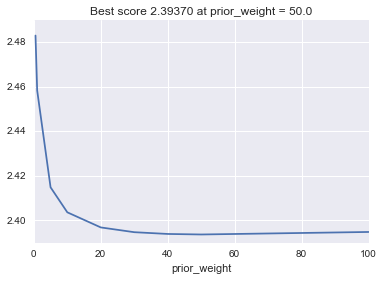

In [73]:
weights = [0.5, 1., 5., 10., 20.,30.,40.,50.,100.]
res = [score(ptrain,'model',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

In [74]:
# Best weight for brand: 40
# Best weight for device: 50

In [75]:
s = 100
kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=s)
predb = np.zeros((ptrain.shape[0],n_classes))
predm = np.zeros((ptrain.shape[0],n_classes))
for itrain, itest in kf:
    train = ptrain.iloc[itrain,:]
    test = ptrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'brand')
    predb[itest,:] = clf.predict_proba(test)
    clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'model')
    predm[itest,:] = clf.predict_proba(test)


In [76]:
w1, w2 = 1, 1.8
log_loss(y, (w1*predb+w2*predm)/(w1+w2))

2.3895194485695672

We have the following variables for this model
- Prior weight
- Weights brand/model
- Seed
- Number of folds

### Test prior weight

In [77]:
s=9999
kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=s)
predb = np.zeros((ptrain.shape[0],n_classes))
predm = np.zeros((ptrain.shape[0],n_classes))
for ws in [10., 20., 30., 40., 50., 60.]:
    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=ws).fit(train,'brand')
        predb[itest,:] = clf.predict_proba(test)
        clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'model')
        predm[itest,:] = clf.predict_proba(test)
    print log_loss(y, (w1*predb+w2*predm)/(w1+w2))

2.38955217791
2.38950495255
2.38949667294
2.38950133797
2.38951136217
2.38952378303


For brand: (consistent with seed)
10: 2.3895645807
20: 2.38951944857
30: 2.3895114353 * Minimum
40: 2.38951560074
50: 2.38952474388
60: 2.38953608403

For device: (consistent with seed)
10: 2.39029824291
20: 2.3895114353 * Minimum
30: 2.38965792994
40: 2.39001784009
50: 2.39043342904
60: 2.39085576399

### Weights brand/model

In [78]:
s=50
kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=s)
predb = np.zeros((ptrain.shape[0],n_classes))
predm = np.zeros((ptrain.shape[0],n_classes))

for itrain, itest in kf:
    train = ptrain.iloc[itrain,:]
    test = ptrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderAgeGroupProb(prior_weight=30.).fit(train,'brand')
    predb[itest,:] = clf.predict_proba(test)
    clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'model')
    predm[itest,:] = clf.predict_proba(test)
print log_loss(y, (w1*predb+w2*predm)/(w1+w2))

2.38951324136


In [48]:
w1, w2 = 1, 1.3
for w2 in [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]:
    print w2, ':', log_loss(y, (w1*predb+w2*predm)/(w1+w2))

1.1 : 2.38934992139
1.2 : 2.38929668366
1.3 : 2.3892800324
1.4 : 2.38929169768
1.5 : 2.38932529917
1.6 : 2.38937587558
1.7 : 2.38943954265
1.8 : 2.38951324136


1.1 : 2.38935143238
1.2 : 2.38930020121
1.3 : 2.389285235 * Minimum (consistent with different seeds)
1.4 : 2.38929832534
1.5 : 2.38933313955
1.6 : 2.38938475374
1.7 : 2.38944931332
1.8 : 2.38952378303

### Random seed

In [56]:
predbs = []
predms = []
for s in random.sample(xrange(99999), 50):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=s)
    predb = np.zeros((ptrain.shape[0],n_classes))
    predm = np.zeros((ptrain.shape[0],n_classes))

    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=30.).fit(train,'brand')
        predb[itest,:] = clf.predict_proba(test)
        clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'model')
        predm[itest,:] = clf.predict_proba(test)
    predbs.append(predb)
    predms.append(predm)
    print s, ':', log_loss(y, (w1*predb+w2*predm)/(w1+w2))

72150 : 2.38977579011
61255 : 2.38967405862
27285 : 2.3895752101
11696 : 2.38967676905
98028 : 2.38954572192
45870 : 2.38946510089
69679 : 2.38939001884
80186 : 2.3896153465
17831 : 2.38988526401
71981 : 2.38942728903
49223 : 2.38955628212
25456 : 2.38953473133
16610 : 2.38975447098
65793 : 2.39010127512
46480 : 2.38951752224
1144 : 2.39015718582
21034 : 2.38984800773
24854 : 2.38983676749
26706 : 2.38967024259
55971 : 2.38945183613
29081 : 2.38956048651
84383 : 2.389803493
8509 : 2.38990635515
33300 : 2.38944579915
15723 : 2.38963095917
48489 : 2.38929440537
57036 : 2.38938996923
88302 : 2.3896301587
65890 : 2.38968032679
74521 : 2.38938524884
70645 : 2.38953387915
34960 : 2.38972380816
77243 : 2.38952086837
48821 : 2.38941726266
18464 : 2.3894336465
74371 : 2.38986295447
91912 : 2.38963631099
77589 : 2.38976102378
64185 : 2.38937159177
26376 : 2.38949583
68088 : 2.38981414279
55882 : 2.38963342789
39997 : 2.38984470005
72232 : 2.38987299001
77460 : 2.38962814178
44674 : 2.38969713619

In [58]:
n = len(predbs)
log_loss(y, w1*sum(predbs)/n+w2*sum(predms)/n)

2.3886149544606239

In [59]:
for n in [1,2,5,10,20,30,40,50]:
    print n, ':', log_loss(y, w1*sum(predbs[0:n])/n+w2*sum(predms[0:n])/n)

1 : 2.38977579011
2 : 2.38919230812
5 : 2.38881288005
10 : 2.38867036335
20 : 2.38868404388
30 : 2.38863625771
40 : 2.38861310556
50 : 2.38861495446


Optimimum around 40 different seeds

### Number of folds

In [63]:
for n_fold in [5, 10, 20, 50, 100, 200, 500]:
    kf = StratifiedKFold(y, n_folds=n_fold, shuffle=True, random_state=s)
    predb = np.zeros((ptrain.shape[0],n_classes))
    predm = np.zeros((ptrain.shape[0],n_classes))

    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=30.).fit(train,'brand')
        predb[itest,:] = clf.predict_proba(test)
        clf = GenderAgeGroupProb(prior_weight=20.).fit(train,'model')
        predm[itest,:] = clf.predict_proba(test)

    print n_fold, ':', log_loss(y, (w1*predb+w2*predm)/(w1+w2))

5 : 2.39093825532
10 : 2.38959281588
20 : 2.38898929513
50 : 2.38890334591
100 : 2.38865502875
200 : 2.38864451041
500 : 2.38856407469
